## Load the Libraries

In [2]:
import numpy as np

import matplotlib.pyplot as plt


from skimage.filters import threshold_multiotsu
from skimage import io,util

## Load the image and cut the data zone off

In [3]:
img=io.imread("Olivine_ECPs_4QBSE/20kV_10nA_TiltX-5_Y3.5_CompoECPs_1.tif")
ref_img=io.imread("Olivine_ECPs_4QBSE/20kV_10nA_TiltX-5_Y3.5_CompoECPs_7.tif")
ref_img=ref_img[0:ref_img.shape[1],:]
img=img[0:img.shape[1],:]
img_u8=util.img_as_uint(img)

We want of course to check, wether it looks okay :D

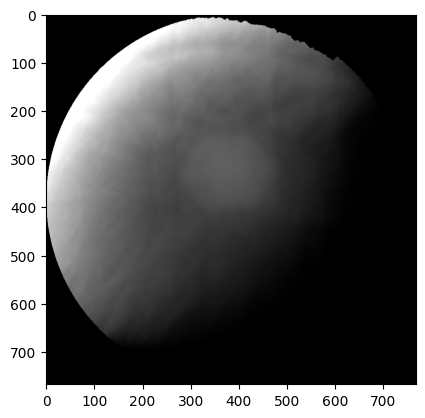

In [4]:
plt.imshow(img,cmap='gray')




In [45]:

X,Y=np.meshgrid(np.arange(0,img.shape[0],1),np.arange(0,img.shape[0],1))

## Trying another approach based on gaussians

In [46]:
def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

In [30]:
# np.arange(0,img.shape[0],1)

c:\Users\lukas\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


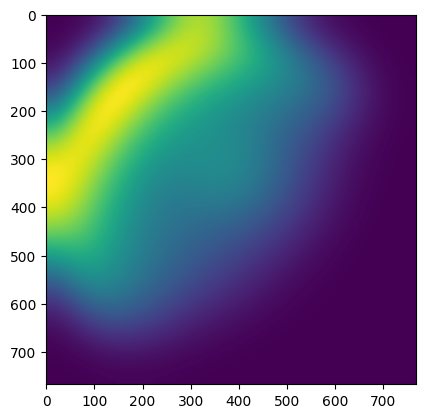

In [74]:
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter
# initial_guess = (1200, 120, 80, 20, 20, 0, 50)
im_gauss=gaussian_filter(img,50)
plt.imshow(im_gauss)
popt,pcov=curve_fit(twoD_Gaussian,(X,Y),im_gauss.ravel())

In [75]:

data_fitted = twoD_Gaussian((X, Y), *popt)

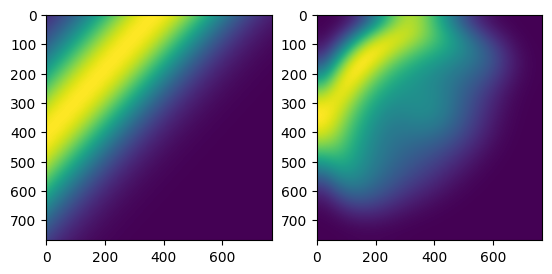

In [103]:
fig,ax=plt.subplots(1,2)
ax[0].imshow(data_fitted.reshape(img.shape))
ax[1].imshow(im_gauss)

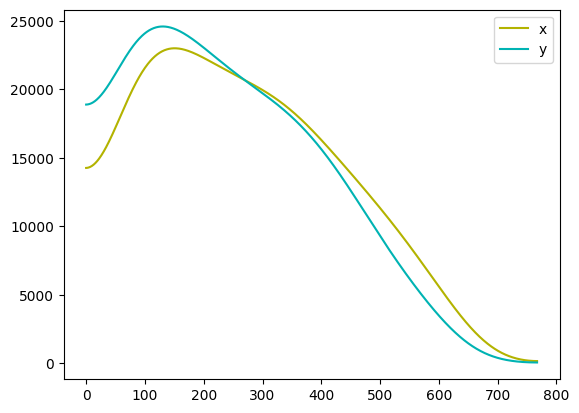

In [105]:
plt.plot(np.mean(im_gauss,1),color=[0.7,0.7,0],label='x')
plt.plot(np.mean(np.transpose(im_gauss),1),color=[0,0.7,0.7],label='y')
plt.legend()

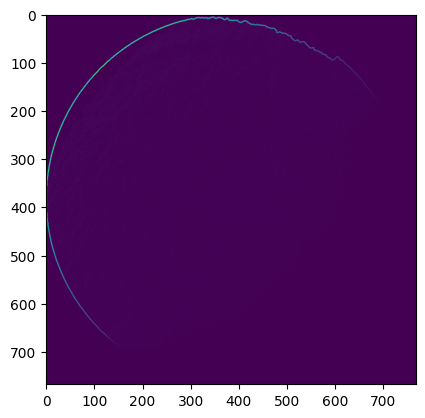

In [80]:
from skimage import filters
edge_scharr = filters.scharr(img)
# figure
plt.imshow(edge_scharr)

In [82]:
from scipy.fft import fft2, fftshift

image_f = np.abs(fftshift(fft2(img)))

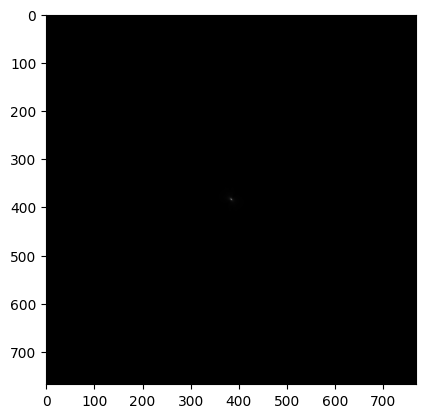

In [87]:
plt.imshow(image_f,cmap='gray')
# plt.imshow(img)

In [ ]:

def angle(dx, dy):
    """Calculate the angles between horizontal and vertical operators."""
    return np.mod(np.arctan2(dy, dx), np.pi)
image_x = 2 * x * np.cos(x**2 + y**2)
image_y = 2 * y * np.cos(x**2 + y**2)

true_angle = angle(image_x, image_y)

## Let's try out how we can restrict it to only the "high quality regime"

In [4]:
# thresholds = threshold_multiotsu(img_u8)

In [5]:
from skimage import data, util, filters, color
from skimage.segmentation import watershed

In [6]:
coins=data.coins()
seeds = np.zeros(img.shape, dtype=int)

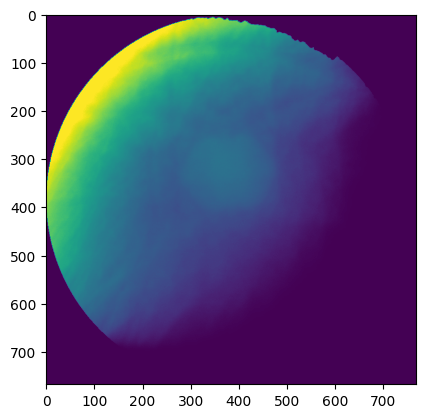

In [7]:
plt.imshow(img)

In [8]:
seeds[50,50]=1
seeds[768-50,768-50]=1
seeds[int(768/2),int(768/2)]=1
seeds[768-50,50]=1
seeds[50,768-50]=1

In [9]:
w0=watershed(img,seeds)

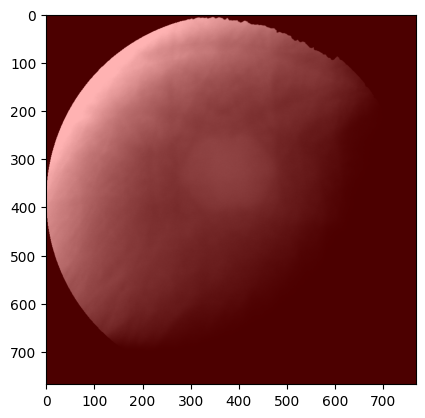

In [10]:
plt.imshow(color.label2rgb(w0, img, bg_label=-1))

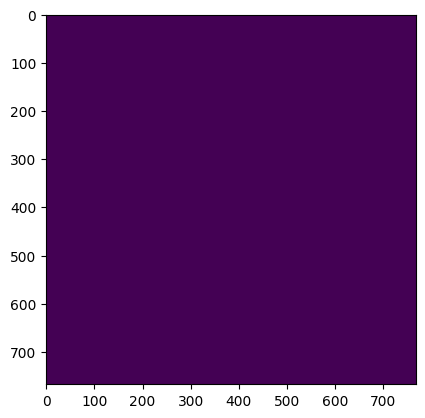

In [11]:
plt.imshow(w0)

## trying RAG


In [12]:
from skimage import data, io, segmentation, color
from skimage import graph
import numpy as np


def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
    graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
    graph.nodes[dst]['mean color'] = (
        graph.nodes[dst]['total color'] / graph.nodes[dst]['pixel count']
    )



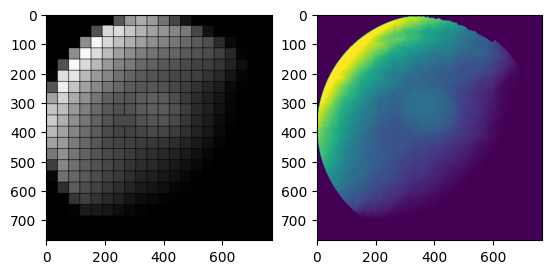

In [13]:

# img = data.coffee()
labels = segmentation.slic(img, compactness=30, n_segments=400, start_label=1,channel_axis=None)
g = graph.rag_mean_color(img, labels)

labels2 = graph.merge_hierarchical(
    labels,
    g,
    thresh=35,
    rag_copy=False,
    in_place_merge=True,
    merge_func=merge_mean_color,
    weight_func=_weight_mean_color,
)

out = color.label2rgb(labels2, img, kind='avg', bg_label=0)
out = segmentation.mark_boundaries(out, labels2, (0, 0, 0))
fig,ax=plt.subplots(1,2)
ax[0].imshow(out)
ax[1].imshow(img)
# io.imshow(out)
# io.show()

## Thresholding


In [14]:
import matplotlib.pyplot as plt
from skimage import data
from skimage.filters import threshold_otsu

(array([295279.,  50700.,  62086.,  68639.,  30347.,  23620.,  18044.,
         14399.,  10417.,  16293.]),
 array([    0. ,  6553.5, 13107. , 19660.5, 26214. , 32767.5, 39321. ,
        45874.5, 52428. , 58981.5, 65535. ]),
 <BarContainer object of 10 artists>)

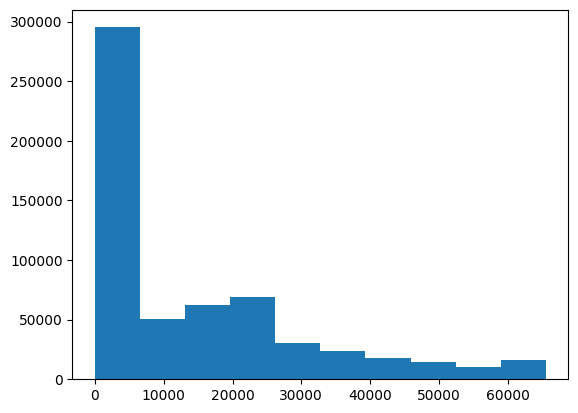

In [15]:
plt.hist(img_u8.ravel())

C:\Users\lukas\AppData\Local\Temp\ipykernel_3376\3188056701.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])


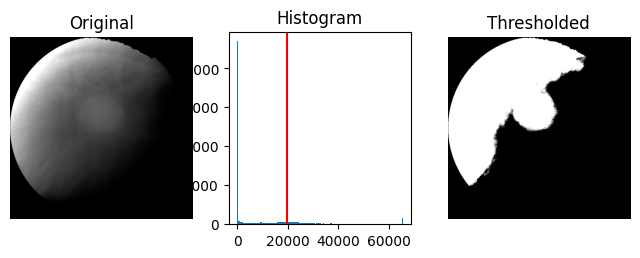

In [16]:
# image = data.camera()
thresh = threshold_otsu(img)
binary = img > thresh

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(img.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

In [17]:
from skimage.filters import try_all_threshold
from skimage import restoration

# img = data.page()

# fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
# plt.show()

In [18]:


# thresh=threshold_mean(img)

In [19]:
background = restoration.rolling_ball(img)

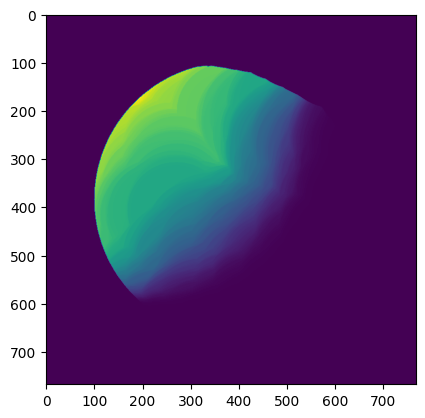

In [20]:
plt.imshow(background)

In [35]:
from skimage import morphology

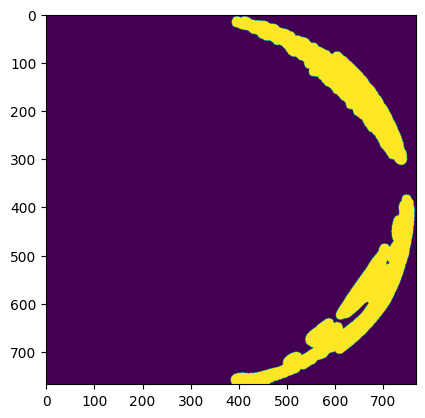

In [48]:
plt.imshow(morphology.binary_dilation(mask2,morphology.disk(10)))

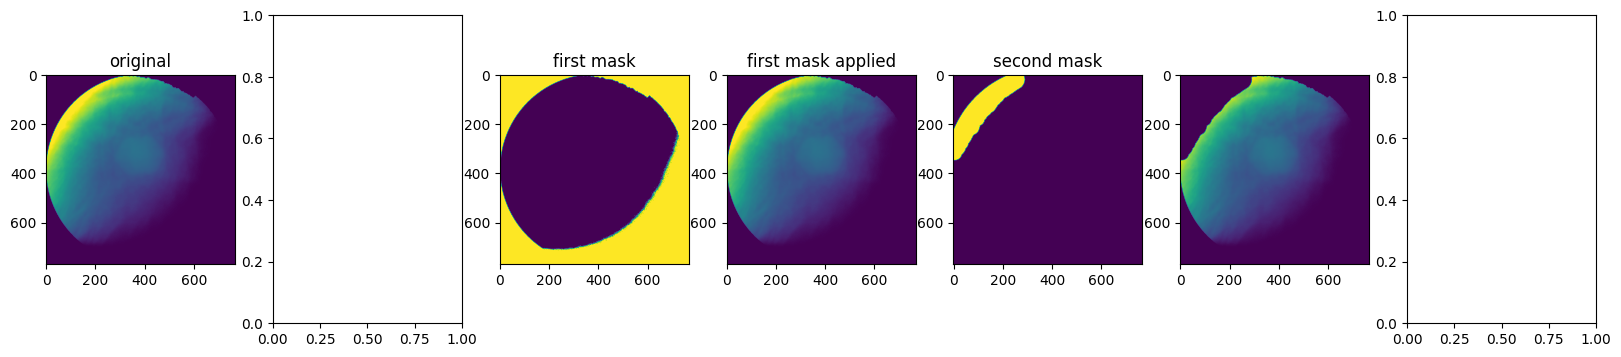

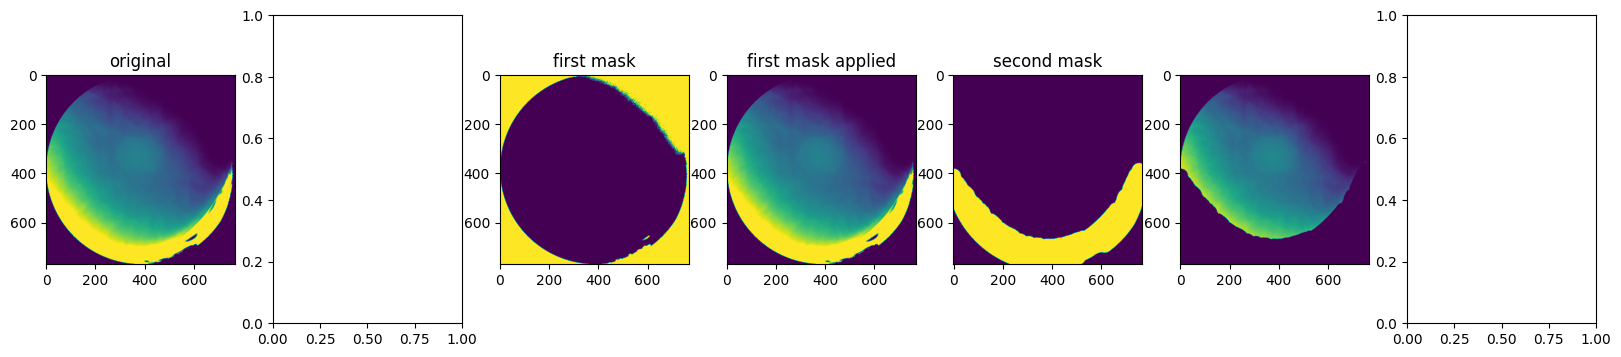

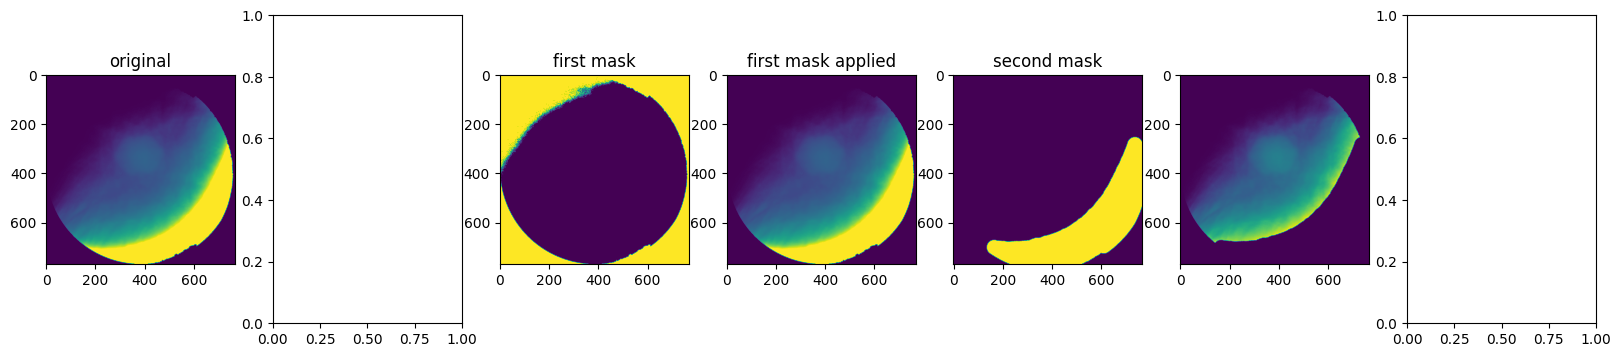

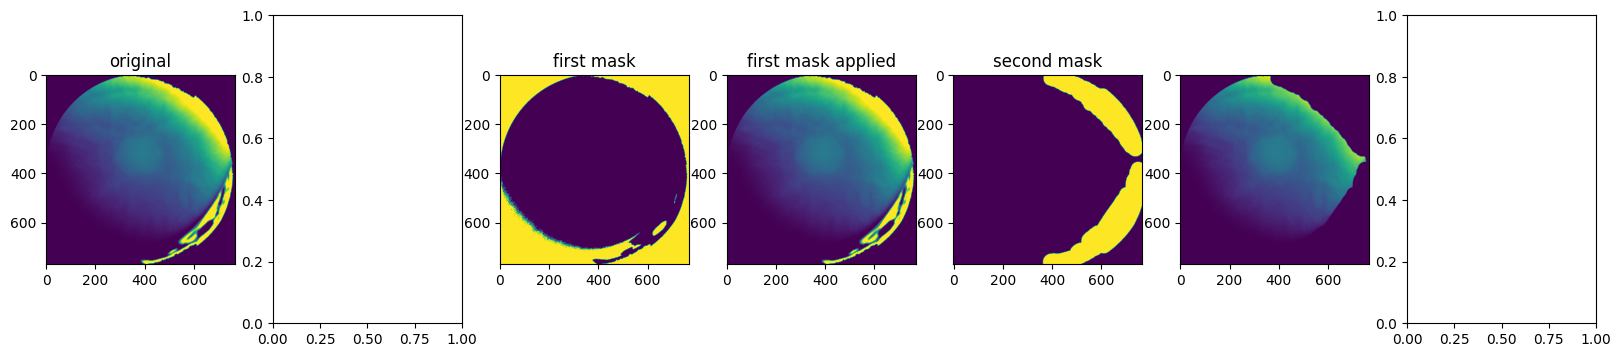

In [53]:
img=io.imread(f"Olivine_ECPs_4QBSE/20kV_10nA_TiltX-5_Y3.5_CompoECPs_{7}.tif")
img=img[0:img.shape[1],:]
img_u8=util.img_as_uint(img)
img_fin=np.zeros((img.shape[0],img.shape[1],4))
mask_fin_inv=np.zeros((img.shape[0],img.shape[1],4))
for i in range(0,4):
    img=io.imread(f"Olivine_ECPs_4QBSE/20kV_10nA_TiltX-5_Y3.5_CompoECPs_{i+1}.tif")
    img=img[0:img.shape[1],:]
    img_u8=util.img_as_uint(img)
    from skimage.filters import threshold_triangle
    thresh=threshold_triangle(img)
    mask=img<thresh
    img_mask_applied=img
    img_mask_applied[mask]=0
    fig,ax=plt.subplots(1,7,figsize=(20,4))
    ax[0].imshow(img)
    ax[0].set_title('original')
    # background = restoration.rolling_ball(img)
    # ax[1].imshow(img-background)
    ax[2].imshow(mask)
    ax[2].set_title('first mask')
    ax[3].imshow(img_mask_applied)
    ax[3].set_title('first mask applied')
    input=img_mask_applied[img_mask_applied!=0]
    thresh2=threshold_triangle(input)
    mask2=img_mask_applied>thresh2
    mask2=morphology.binary_dilation(mask2,morphology.disk(30))
    ax[4].imshow(mask2)

    img_mask_applied_2=img_mask_applied
    img_mask_applied_2[mask2]=0
    ax[4].set_title('second mask')
    ax[5].imshow(img_mask_applied_2)
    
    # background2 = restoration.rolling_ball(img_mask_applied_2)
    # ax[6].imshow(img_mask_applied_2-background2)
    img_fin[:,:,i]=img_mask_applied_2
    mask_fin_inv[:,:,i]=(mask+mask2)==0

    

C:\Users\lukas\AppData\Local\Temp\ipykernel_3376\3303637307.py:2: RuntimeWarning: invalid value encountered in divide
  corr_img=np.sum(img_fin,2)/np.sum(mask_fin_inv,2)


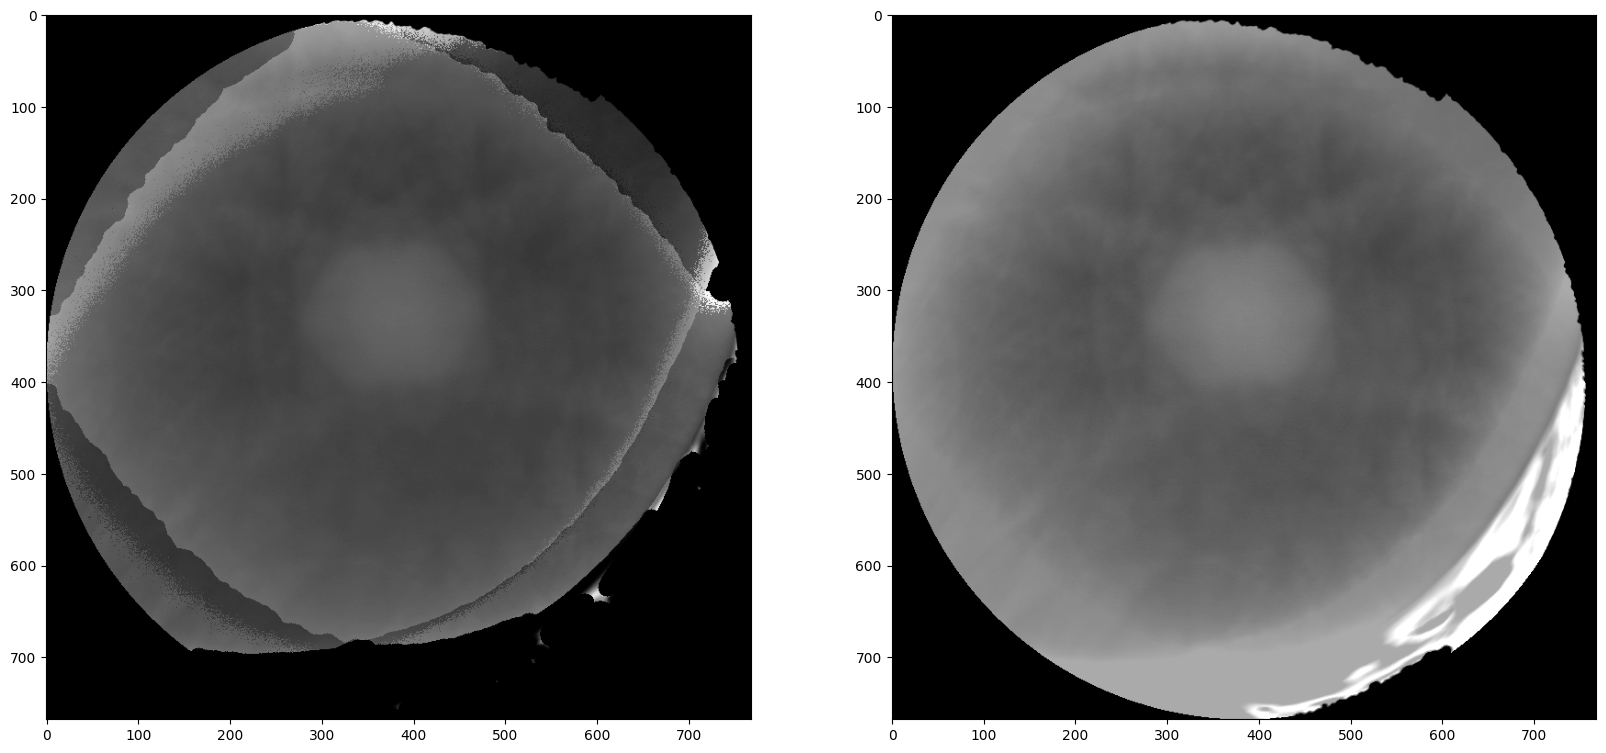

In [51]:
fig,ax=plt.subplots(1,2,figsize=(20,25))
corr_img=np.sum(img_fin,2)/np.sum(mask_fin_inv,2)
corr_img[np.sum(mask_fin_inv,2)==0]=0
ax[0].imshow(corr_img,cmap='gray')
ax[1].imshow(ref_img,cmap='gray')

In [ ]:
mask_fin_inv